# Caffe2 TSNE example

This example scripts shows you how to properly load a custom Caffe2 extension, usually in the form of a dynamic library, into Caffe2 Python and then use it.

Caffe2 uses a registration pattern, and as a result, one simply needs to use the dyndep module in caffe2.python to load the extension library. What happens under the hood is that the corresponding operators get registered into the Caffe2 operator registry, and then one can create such related operators using the predefined name and calling convention.

We will use the TSNE example to show this. If you haven't checked out the C++ part, read the source code, build it, and then invoke this ipython notebook.

In [1]:
# First, we will import the necessary dependencies.
%matplotlib inline
import os
from matplotlib import pyplot
import numpy as np
import struct

from caffe2.python import core, dyndep, workspace
from caffe2.proto import caffe2_pb2

In [2]:
# This is what you will need to import your custom library.
# It will load the .so file into Python, and register the
# corresponding operators to the Caffe2 operator registry.
dyndep.InitOpsLibrary('libcaffe2_tsne.so')

In [3]:
# Now, since we know that our custom implementation is for
# the TSNE operator, we will do a sanity check to make sure
# it is there.
'TSNE' in workspace.RegisteredOperators()

True

In [4]:
# We will create a quick helper function to load the MNIST dataset.
# If you don't have it, you can download it here:
#     http://yann.lecun.com/exdb/mnist/
# Make sure you gunzip it after downloading. Some browsers may do
# that automatically for you.
def read_mnist(dataset = "training", path = "."):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """
    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError, "dataset must be 'testing' or 'training'"

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    return lbl, img

In [5]:
# We will read in the MNIST dataset, and then take 5000
# examples for the sake of speed.
lbl, img = read_mnist()
img = img.reshape(60000, 28*28).astype(np.double)[:5000]
lbl = lbl[:5000]

In [6]:
# Now, to create an operator for Caffe2 that does TSNE, one simply
# provides the operator name, in this case "TSNE", the input name,
# the output name, and the necessary arguments.
# In the case of TSNE, we will specify that the output dims is 2,
# and we will run the iteration a maximum of 1000 times.
op = core.CreateOperator("TSNE", "img", "Y", dims=2, max_iter=1000)

In [7]:
# The above essentially creates a protocol buffer object that defines
# the operator. We can serialize it into a human readable format.
print(str(op))

input: "img"
output: "Y"
name: ""
type: "TSNE"
arg {
  name: "dims"
  i: 2
}
arg {
  name: "max_iter"
  i: 1000
}



In [8]:
# So, to run it, the easiest thing to do is:
# (1) Load the input to the workspace,
# (2) Run the operator,
# (3) Fetch the output from the workspace.
#
# Of course, for more complex runs, you can add this operator
# to either a net or a plan - see the official Caffe2 docs for
# detailed instructions.
workspace.FeedBlob("img", img)
workspace.RunOperatorOnce(op)
Y = workspace.FetchBlob("Y")

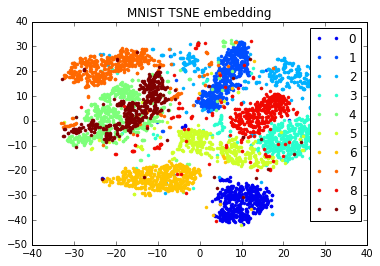

In [9]:
# In this case, let's visualize how the TSNE embedding looks like.
my_colors = pyplot.get_cmap("jet")(np.linspace(0.1, 1, 10))

for i in range(10):
    pyplot.plot(Y[lbl==i, 0], Y[lbl==i, 1], '.', color=my_colors[i], label=str(i))
pyplot.legend()
pyplot.title("MNIST TSNE embedding")

This is it! You can write your own implementations and very easily register it against Caffe2 in a similar fashion. Happy brewing!